# Item2Vec
In this notebook, we demonstarte how to learn embeddigns for items (products) from transactional data using Word2Vec. Orders are interpreted as sentences and product are interpreted as words.

### Data
We use an external dataset from the Instacart Market Basket Analysis competition (see `datasets.md/Instacart`). Please download and unzip the dataset to `data` folder before running this notebook.

### References
1. Barkan O., Koenigstein N. -- Item2Vec: Neural Item Embedding for Collaborative Filtering, 2016
1. Arora S., Warrier D. -- Decoding Fashion Contexts Using Word Embeddings, 2016

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import numpy as np
import os

from tabulate import tabulate
import glob
from IPython.display import display, HTML
import multiprocessing as mp
print('Number of CPU cores:', mp.cpu_count())

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances

pd.options.display.max_rows = 20
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)
sns.set_style("whitegrid")


#
# Helper functions 
#
def to_readable(v):
    value = round(v,2) if isinstance(v, float) else v
    if value < 1000:
        return str(value)
    elif value < 1000000:
        return str(round(value/1000,1)) + 'K'
    elif value >= 1000000:
        return str(round(value/1000000,1)) + 'M'
    return value

def print_df(df, rows = 10, print_df_mode='psql'):
    if print_df_mode == 'psql':
        print(tabulate(df.head(rows), headers='keys', tablefmt='psql'))
    else:
        display(df.head(rows))
    print(f'{len(df)} rows x {len(df.columns)} columns')

Number of CPU cores: 12


# Step 1: Data Loading and Preview

In [ ]:
DATA_PATH = '../../tensor-house-data/recommendations/instacart'
files_list = glob.glob(f'{DATA_PATH}/*.csv')

data_dict = {}
for file in files_list:
    print(f'\n\nReading: {file}')
    data = pd.read_csv(file)
    print(data.info(null_counts=True))

    print(f'\nSample ({file}):')
    display(HTML(data.sample(min(10, len(data))).to_html()))
    print(f'\nDataset stats ({file}):')
    display(HTML(data.describe().T.to_html()))
    
    print(f'\nColumn stats ({file}):')
    for col in data.columns:
        print(f'\nColumn {col} has {data[col].nunique()} unique values')
        print(f"Example of values: {data[col].unique()[:10]}")

    data_dict[file.split('/')[-1].split('.')[0]] = data
    
data_dict.keys()

# Step 2: Data Preparation

In [11]:
order_product_cnt_ds = data_dict['order_products__prior'].groupby('order_id').count()[['product_id']]
order_product_cnt_ds.columns = ['product_cnt']
order_ds = data_dict['orders'].merge(order_product_cnt_ds, left_on='order_id', right_index=True)      # add product counters to orders
order_ds.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214874 entries, 0 to 3421081
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
 7   product_cnt             int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 220.7+ MB


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_cnt
2010925,1430329,120840,prior,6,5,18,3.0,8
2426205,1937160,145988,prior,2,2,10,13.0,1
1574622,2288006,94578,prior,3,4,9,30.0,2
2134944,3104016,128393,prior,12,3,16,6.0,20
3088810,1978604,186286,prior,1,5,10,NaN,1


In [12]:
total_user = len(order_ds.user_id.unique())
total_order = len(order_ds)
total_ordered_product = len(data_dict['order_products__prior'])
unique_products = len(data_dict['order_products__prior'].product_id.unique())

print("total user = {}".format(to_readable(total_user)))
print("total order = {} ({} orders per user)".format(to_readable(total_order), to_readable(total_order/total_user) ))
print("total product = ", to_readable(unique_products))
print("total ordered product  = {} ({} orders per product)".format(to_readable(total_ordered_product), to_readable(total_ordered_product/unique_products) ))

total user = 206.2K
total order = 3.2M (15.59 orders per user)
total product =  49.7K
total ordered product  = 32.4M (652.91 orders per product)


# Step 3: Prepare a Product Corpus

We now proceed to learning informative semantic representation for items (products) using word2vec model. The first step is to build a product corpus.

In [19]:
merge_order_product_df = data_dict['order_products__prior'].merge(order_ds, on='order_id' )

order_product_df = merge_order_product_df\
    .sort_values(['user_id','order_id','add_to_cart_order'])[['order_id','product_id', 'add_to_cart_order']]

# Print the input 
print_df(order_product_df)

print('Creating sequences based on transactions...')
order_product_list = order_product_df.values.tolist()

# Each entry of a corpus is one order represented by a chronologically sorted sequence of product IDs
print('Preparing a corpus of items...')
product_corpus = []     
sentence = []
new_order_id = order_product_list[0][0]
for (order_id, product_id, add_to_cart) in tqdm(order_product_list):
    if new_order_id != order_id:
        product_corpus.append(sentence)
        sentence = []
        new_order_id = order_id
    sentence.append(str(product_id))

+---------+------------+--------------+---------------------+
|         |   order_id |   product_id |   add_to_cart_order |
|---------+------------+--------------+---------------------|
| 4089398 |     431534 |          196 |                   1 |
| 4089399 |     431534 |        12427 |                   2 |
| 4089400 |     431534 |        10258 |                   3 |
| 4089401 |     431534 |        25133 |                   4 |
| 4089402 |     431534 |        10326 |                   5 |
| 4089403 |     431534 |        17122 |                   6 |
| 4089404 |     431534 |        41787 |                   7 |
| 4089405 |     431534 |        13176 |                   8 |
| 4488095 |     473747 |          196 |                   1 |
| 4488096 |     473747 |        12427 |                   2 |
+---------+------------+--------------+---------------------+
32434489 rows x 3 columns
Creating sequences based on transactions...
Preparing a corpus of items...


# Step 4: Train Item2Vec model

To train the model, we use the Word2Vec implementation from Gensim adjusting the following parameters:
* sentences = product_corpus
* window - maximum distance between the current and predicted word within a sentence.
* size - dimensionality of the word vectors.
* min_count - ignores all words with total frequency lower than this.

In [21]:
TRAIN_ITEM_MODEL = True   # True - create a new model, False - load a previosuly created model
LOGGING_ELABLED = False
MODEL_DIR = 'models'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [22]:
if LOGGING_ELABLED:
    import logging
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
    
WORD_DIM = 200
model_filename = f'models/item2vec.{WORD_DIM}d.model'
if TRAIN_ITEM_MODEL:
    model = Word2Vec(product_corpus, 
                window=5, 
                size=WORD_DIM, 
                workers=mp.cpu_count() - 2, 
                min_count=100)
    
    model.save(model_filename)
    print(f'Model saved to [{model_filename}]')
    
else:
    model = Word2Vec.load(model_filename)
    print(f'Model loaded from [{model_filename}]')

Model saved to [models/item2vec.200d.model]


In [23]:
def to_product_name(id, columns='product_name'):
    return data_dict['products'][data_dict['products'].product_id==id][columns].values.tolist()[0]

def most_similar_readable(model, product_id, topn=10):
    similar_list = [(product_id, 1.0)] + model.wv.most_similar(str(product_id), topn=topn)
    return pd.DataFrame([( to_product_name(int(id)), int(id), similarity ) for (id, similarity) in similar_list],
                        columns=['product', 'product_id', 'similarity'])

In [85]:
#
# Reality check: Show the nearest neighbors for several common products 
#
for product_id in [13176, 39180, 2326]:
    print_df(most_similar_readable(model, product_id)) 

+----+--------------------------------------+--------------+--------------+
|    | product                              |   product_id |   similarity |
|----+--------------------------------------+--------------+--------------|
|  0 | Bag of Organic Bananas               |        13176 |     1        |
|  1 | Organic Banana                       |        37067 |     0.744026 |
|  2 | Banana                               |        24852 |     0.720234 |
|  3 | Organic D'Anjou Pears                |        22825 |     0.524337 |
|  4 | Organic Bosc Pear                    |        46969 |     0.487394 |
|  5 | Organic Raspberries                  |        27966 |     0.485564 |
|  6 | Organic Kiwi                         |        39928 |     0.47618  |
|  7 | Organic Bartlett Pear                |        43122 |     0.470581 |
|  8 | Organic Green Seedless Grapes        |        38777 |     0.466974 |
|  9 | Organic Large Extra Fancy Fuji Apple |        19057 |     0.464857 |
+----+------

# Step 5: Visualize the Semantic Space Using t-SNE

We demonstrate that the semantic space has a meaningful internal structure aligned with the typical product taxonomy (departments and aisles).

In [26]:
#
# Prepare the embeddings for t-SNE
#
word_vectors = model.wv
vocab = list(model.wv.vocab.keys())
item2vector_dict = {arg:model.wv[arg] for arg in vocab}
X = pd.DataFrame(item2vector_dict).T.values
X.shape, len(vocab), vocab[0]

((20067, 200), 20067, '196')

In [38]:
#
# Perform t-SNE
#
distance_matrix = pairwise_distances(X, X, metric='cosine', n_jobs=-1)
tsne = TSNE(metric="precomputed", n_components=2, verbose=1, perplexity=500, n_iter=1000)
tsne_results = tsne.fit_transform(distance_matrix)

[t-SNE] Computing 1501 nearest neighbors...
[t-SNE] Indexed 20067 samples in 0.370s...
[t-SNE] Computed neighbors for 20067 samples in 14.589s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20067
[t-SNE] Computed conditional probabilities for sample 2000 / 20067
[t-SNE] Computed conditional probabilities for sample 3000 / 20067
[t-SNE] Computed conditional probabilities for sample 4000 / 20067
[t-SNE] Computed conditional probabilities for sample 5000 / 20067
[t-SNE] Computed conditional probabilities for sample 6000 / 20067
[t-SNE] Computed conditional probabilities for sample 7000 / 20067
[t-SNE] Computed conditional probabilities for sample 8000 / 20067
[t-SNE] Computed conditional probabilities for sample 9000 / 20067
[t-SNE] Computed conditional probabilities for sample 10000 / 20067
[t-SNE] Computed conditional probabilities for sample 11000 / 20067
[t-SNE] Computed conditional probabilities for sample 12000 / 20067
[t-SNE] Computed conditional probabilities for 

In [39]:
df_semantic_item = pd.DataFrame({'product_id': vocab})
df_semantic_item['tsne-2d-one'] = tsne_results[:,0]
df_semantic_item['tsne-2d-two'] = tsne_results[:,1]
df_semantic_item['product_id'] = df_semantic_item['product_id'].astype(int)

df_semantic_item = df_semantic_item.merge(data_dict['products'], on='product_id', how='left')
df_semantic_item = df_semantic_item.merge(data_dict['aisles'], on='aisle_id', how='left')
df_semantic_item = df_semantic_item.merge(data_dict['departments'], on='department_id', how='left')

print_df(df_semantic_item.sample(5))

n_aisle = df_semantic_item['aisle'].nunique()
n_department = df_semantic_item['department'].nunique()
print(f"Unique aisles: {n_aisle}") 
print(f"Unique departments: {n_department}")

+-------+--------------+---------------+---------------+---------------------------------------------------+------------+-----------------+---------------------+--------------+
|       |   product_id |   tsne-2d-one |   tsne-2d-two | product_name                                      |   aisle_id |   department_id | aisle               | department   |
|-------+--------------+---------------+---------------+---------------------------------------------------+------------+-----------------+---------------------+--------------|
| 16692 |        12741 |      33.5296  |       1.86366 | Chocolate Almond Coconut High Protein & Fiber Bar |          3 |              19 | energy granola bars | snacks       |
| 18421 |        24447 |      25.106   |      19.3947  | Honest T Pomegranate Red Herbal Tea               |         94 |               7 | tea                 | beverages    |
|  8016 |        37752 |     -40.181   |      -5.07893 | Dinner Rolls                                      |       

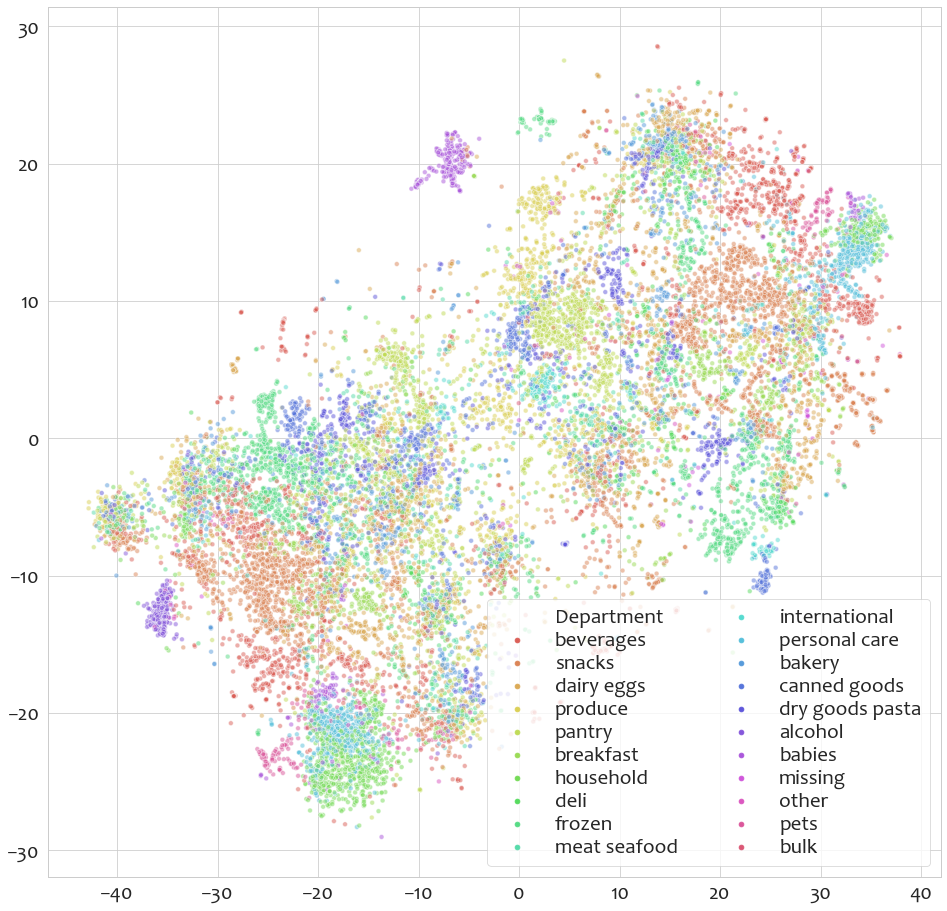

In [69]:
#
# Visualize the entire semantic space and its mapping to the departments
#
df_semantic_item.rename(columns={'department': 'Department'}, inplace=True)
plt.figure(figsize=(16, 16));
sns.set_context("paper", font_scale = 2.4);
sns.set_style({'font.family':'Candara', 'font.serif':['Candara']});
g = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='Department',
    palette=sns.color_palette("hls", n_department),
    data=df_semantic_item,
    legend="full",
    alpha=0.5
);
g.set(xlabel=None);
g.set(ylabel=None);
plt.legend(loc='lower right', labelspacing=0.15, ncol=2)
g.figure.savefig("item_space_tsne.pdf");
plt.show();

Products in the selected aisles: 2706


<Figure size 1152x1152 with 0 Axes>

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

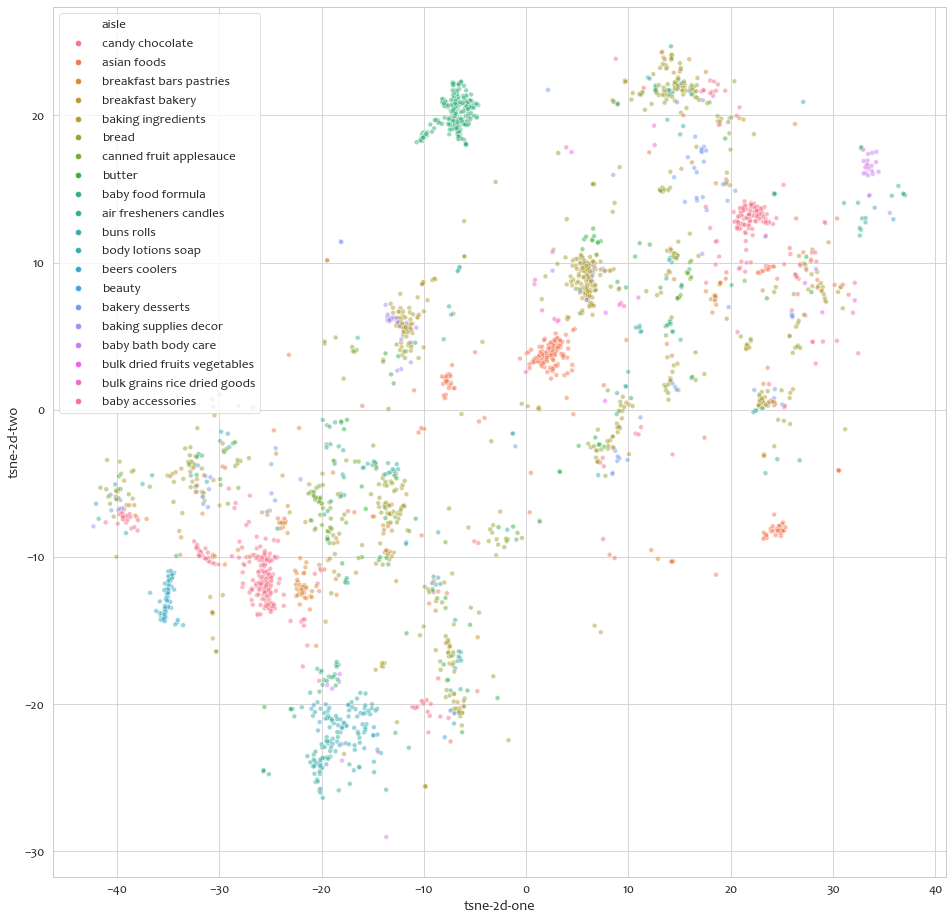

In [47]:
#
# Visualize the mapping between the semantic space and aisles
#
aisle_list = sorted(df_semantic_item['aisle'].unique())
aisle_set = aisle_list[:20]   # take a subset of aisles to keep it readable

print(f'Products in the selected aisles: {df_semantic_item[df_semantic_item.aisle.isin(aisle_set)].shape[0]}')
plt.figure(figsize=(16, 16))
sns.scatterplot(
   x="tsne-2d-one", y="tsne-2d-two",
   hue='aisle',
   data=df_semantic_item[df_semantic_item.aisle.isin(aisle_set)],
   legend="full",
   alpha=0.5
)
plt.show()

# Step 6: Compare the Original Semantic Space and Its t-SNE Projection

In this section, we compare the original (200 dimensional) semantic space with its t-SNE projection.

We demonstrate that rhe high-dimensional semantic space is better aligned with traditional labels (department, asile) than t-SNE projection. More basic projection methods provide event worse results - the SVD projection below is not aligned with the labels at all. However, the aligment between the traditional labels and semantic space is very weak (negative silhouette scores) anyways. This does not mean that the semantic space has no meanigful structure - the structure is just different from product depertment taxonomy. We study the strucutre in mode detail in Customer2Vec model.  

In [42]:
from sklearn.metrics import silhouette_samples, silhouette_score

for space_name, space in {'TSNE': tsne_results, 'raw latent space': model.wv.vectors}.items():
    for entity in ['department', 'aisle']:
        silhouette_avg = silhouette_score(space, df_semantic_item[entity], metric="cosine")
        print(f"The number of unique {entity}s is {df_semantic_item[entity].nunique()} " +\
              f"and the average silhouette_score on {space_name} is : {silhouette_avg:.4}")

The number of unique departments is 21 and the average silhouette_score on TSNE is : -0.7391
The number of unique aisles is 134 and the average silhouette_score on TSNE is : -0.8775
The number of unique departments is 21 and the average silhouette_score on raw latent space is : -0.05101
The number of unique aisles is 134 and the average silhouette_score on raw latent space is : -0.1159


<Figure size 576x576 with 0 Axes>

<AxesSubplot:xlabel='svd-2d-one', ylabel='svd-2d-two'>

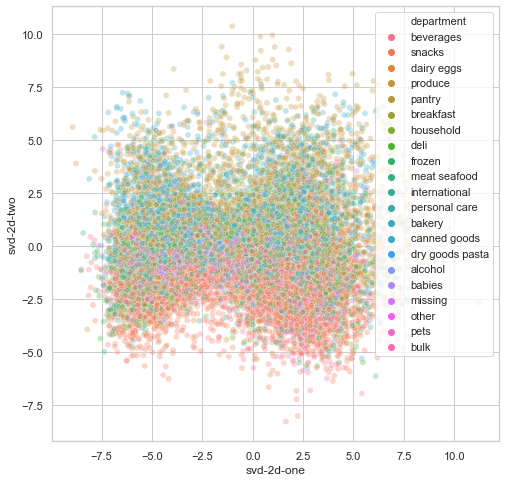

In [43]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X)

df_svd = pd.DataFrame({'product_id': vocab})
df_svd['svd-2d-one'] = X_reduced[:,0]
df_svd['svd-2d-two'] = X_reduced[:,1]
df_svd['product_id'] = df_svd['product_id'].astype(int)

df_svd = df_svd.merge(data_dict['products'], on='product_id', how='left')
df_svd = df_svd.merge(data_dict['aisles'], on='aisle_id', how='left')
df_svd = df_svd.merge(data_dict['departments'], on='department_id', how='left')

plt.figure(figsize=(8, 8))
sns.scatterplot(
        x="svd-2d-one", y="svd-2d-two",
        hue='department',
        data=df_svd,
        legend="full",
        alpha=0.3
    )
plt.show()